<a href="https://colab.research.google.com/github/paciello1899922/CrowdCounting/blob/main/CrowdCounting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
from google.colab.patches import cv2_imshow
import scipy.io as io
import PIL.Image as Image
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from torchvision import utils
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import transform
import h5py

In [2]:
!unzip /content/drive/MyDrive/DatasetCrowd/jhu_crowd_v2.0.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: jhu_crowd_v2.0/val/images/2252.jpg  
  inflating: jhu_crowd_v2.0/val/images/0085.jpg  
  inflating: jhu_crowd_v2.0/val/images/2398.jpg  
  inflating: jhu_crowd_v2.0/val/images/3315.jpg  
  inflating: jhu_crowd_v2.0/val/images/3869.jpg  
  inflating: jhu_crowd_v2.0/val/images/2005.jpg  
  inflating: jhu_crowd_v2.0/val/images/2727.jpg  
  inflating: jhu_crowd_v2.0/val/images/2717.jpg  
  inflating: jhu_crowd_v2.0/val/images/3583.jpg  
  inflating: jhu_crowd_v2.0/val/images/1566.jpg  
  inflating: jhu_crowd_v2.0/val/images/0506.jpg  
  inflating: jhu_crowd_v2.0/val/images/0068.jpg  
  inflating: jhu_crowd_v2.0/val/images/3596.jpg  
  inflating: jhu_crowd_v2.0/val/images/0343.jpg  
  inflating: jhu_crowd_v2.0/val/images/3487.jpg  
  inflating: jhu_crowd_v2.0/val/images/0349.jpg  
  inflating: jhu_crowd_v2.0/val/images/3749.jpg  
  inflating: jhu_crowd_v2.0/val/images/1107.jpg  
  inflating: jhu_crowd_v2.0/val/images/1192.jpg  


In [3]:
main_root = '/content/jhu_crowd_v2.0'
test_path = os.path.join(main_root,'test','images')
train_path = os.path.join(main_root,'train','images')
val_path = os.path.join(main_root,'val','images')
path_set = [train_path]


In [4]:
images = [] 
for path in path_set:
  for image in glob.glob(os.path.join(path, '*.jpg')):
    images.append(image)
print(image)

/content/jhu_crowd_v2.0/train/images/0764.jpg


In [5]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

/content/jhu_crowd_v2.0/train/images/0528.jpg


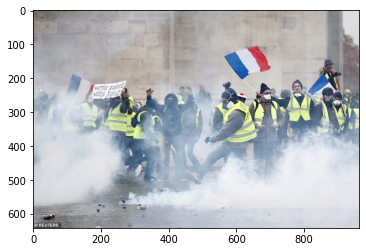

In [6]:
print(images[100])
plt.imshow(Image.open(images[100]))

In [ ]:
np.set_printoptions(threshold=np.inf)
images.sort()
for img_path in images:
    
    heads_annotation = img_path.replace('.jpg','.txt').replace('images', 'gt')
    if os.stat(heads_annotation).st_size!=0:
      heads = pd.read_csv(heads_annotation, delimiter=' ', header=None)
    img= plt.imread(img_path)
    print(img.shape)
    k = np.zeros((img.shape[0],img.shape[1]))
    for i in range (0,len(heads)):
      if heads.iloc[i,1]<img.shape[0] and heads.iloc[i,0]<img.shape[1]:
        k[int(heads.iloc[i,1]),int(heads.iloc[i,0])]=1.0
    k = gaussian_filter_density(k)
    #with h5py.File(img_path.replace('.jpg','.h5').replace('images','gt'), 'w') as hf:
     # hf['density'] = k
    